# Iterative Quantum Phase Estimation Algorithm

The goal of this tutorial is to understand how the Iterative Phase Estimation (IPE) algorithm works, why would we use the IPE algorithm instead of the QPE (Quantum Phase Estimation) algorithm and how to build it with Qiskit using the same circuit exploiting reset gate and the `c_if` method that allows to apply gates conditioned by the values stored in a classical register, resulting from previous measurements.

**References**

- [Section 2 of Lab 4: Iterative Phase Estimation (IPE) Algorithm](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm) 

- [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, assemble, Aer
from qiskit.tools.visualization import plot_histogram
from math import pi
import matplotlib.pyplot as plt

## Conditioned gates: the c_if method

Before starting the IPE algorithm, we will give a brief tutorial about the Qiskit conditional method, c_if, as it goes into building the IPE circuit.

`c_if` is a function (actually a method of the gate class) to perform conditioned operations based on the value stored previously in a classical register. With this feature you can apply gates after a measurement in the same circuit conditioned by the measurement outcome.

For example, the following code will execute the $X$ gate if the value of the classical register is $0$.

In [2]:
q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')
qc = QuantumCircuit(q, c)
qc.h(0)
qc.measure(0,0)
qc.x(0).c_if(c, 0)
qc.draw(output='mpl')

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

We highlight that the method c_if expects as the first argument a whole classical register, not a single classical bit (or a list of classical bits), and as the second argument a value in decimal representation (a non-negative integer), not the value of a single bit, 0, or 1 (or a list/string of binary digits).

Let's make another example. Consider that we want to perform a bit flip on the third qubit after the measurements in the following circuit, when the results of the measurement of $q_0$ and $q_1$ are both $1$.

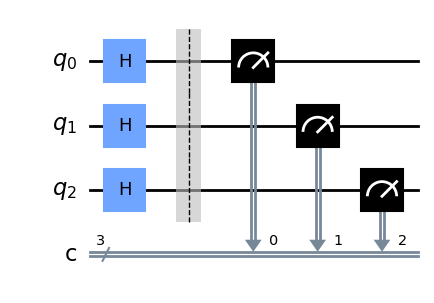

In [3]:
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
qc = QuantumCircuit(q, c)
qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.barrier()
qc.measure(q,c)
qc.draw('mpl')

We want to apply the $X$ gate, only if both the results of the measurement of $q_0$ and $q_1$ are $1$. We can do this using the c_if method, conditioning the application of $X$ depending on the value passed as argument to c_if.

We will have to encode the value to pass to the c_if method such that it will check the values 011 and 111 (in binary representation), since it does not matter what $q_2$ is measured as.

The 2 integer values in decimal representation:


<img src="../../images/binary.png" width="50%" >


We can check the solutions using the bin() method in python (the prefix `0b` indicates the binary format).

In [4]:
print(bin(3))
print(bin(7))

0b11
0b111


So we have to apply $X$ to $q_2$ using c_if  two times, one for each value corresponding to 011 and 111.

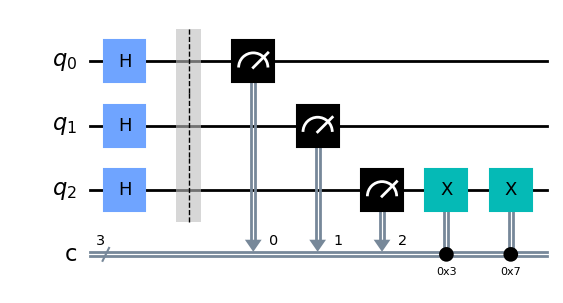

In [5]:
q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
qc = QuantumCircuit(q, c)
qc.h(0)
qc.h(1)
qc.h(2)
qc.barrier()
qc.measure(q,c)

qc.x(2).c_if(c, 3) # for the 011 case
qc.x(2).c_if(c, 7) # for the 111 case

qc.draw(output='mpl')

## IPE

The motivation for using the IPE algorithm is that QPE algorithm works fine for short depth circuits but when the circuit starts to grow, it doesn't work properly due to gate noise and decoherence times.

The detailed explanation of how the algorithm works can be found in [Iterative Phase Estimation (IPE) Algorithm](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm). To understand QPE in depth, you can see also [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html).

### IPE example with a 1-qubit gate for $U$

We want to apply the IPE algorithm to estimate the phase for a 1-qubit operator $U$.  For example, here we use the $S$-gate.

Let's apply the IPE algorithm to estimate the phase for $S$-gate.
Its matrix is 
$$ S = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{2}\\ 
\end{bmatrix}$$

That is, the $S$-gate adds a phase $\pi/2$ to the state $|1\rangle$, leaving unchanged the phase of the state $|0\rangle$

$$ S|1\rangle = e^\frac{i\pi}{2}|1\rangle $$

In the following, we will use the notation and terms used in [Section 2 of lab 4](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm).

Let's consider to estimate the phase $\phi=\frac{\pi}{2}$ for the eigenstate $|1\rangle$, we should find $\varphi=\frac{1}{4}$ (where $\phi = 2 \pi \varphi$). Therefore to estimate the phase we need exactly 2 phase bits, i.e. $m=2$, since $1/2^2=1/4$. So $\varphi=0.\varphi_1\varphi_2$.

Remember from the theory that for the IPE algorithm, $m$ is also the number of iterations, so we need only $2$ iterations or steps.

First, we initialize the circuit. IPE works with only 1 auxiliary qubit, instead of $m$ counting qubits of the QPE algorithm. Therefore, we need 2 qubits, 1 auxiliary qubit and 1 for the eigenstate of $U$-gate, and a classical register of 2 bits, for the phase bits $\varphi_1$, $\varphi_2$.

In [6]:
nq = 2
m = 2
q = QuantumRegister(nq,'q')
c = ClassicalRegister(m,'c')

qc_S = QuantumCircuit(q,c)

#### First step

Now we build the quantum circuit for the first step, that is, the first iteration of the algorithm, to estimate the least significant phase bit $\varphi_m$, in this case $\varphi_2$. For the first step we have 3 sub-steps:
- initialization
- application of the Controlled-$U$ gates
- measure of the auxiliary qubit in x-basis

##### Initialization

The initialization consists of application the Hadamard gate to the auxiliary qubit and the preparation of the eigenstate $|1\rangle$.

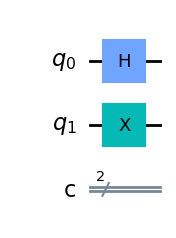

In [7]:
qc_S.h(0)
qc_S.x(1)
qc_S.draw('mpl')

#### Application of the Controlled-$U$ gates

Then we have to apply $2^t$ times the Controlled-$U$ operators (see also in the docs [Two qubit gates](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html#Two-qubit-gates)), that, in this example, is the Controlled-$S$ gate ($CS$ for short).

To implement $CS$ in the circuit, since $S$ is a phase gate, we can use the controlled phase gate $\text{CP}(\theta)$, with $\theta=\pi/2$.

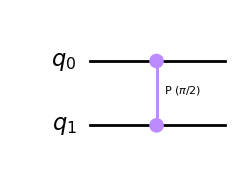

In [8]:
cu_circ = QuantumCircuit(2)
cu_circ.cp(pi/2,0,1)
cu_circ.draw('mpl')

Let's apply $2^t$ times $\text{CP}(\pi/2)$. Since for the first step $t=m-1$, and $m=2$, we have $2^t=2$.

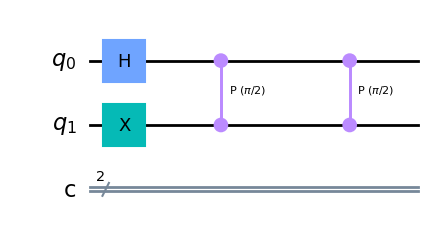

In [9]:
for _ in range(2**(m-1)):
    qc_S.cp(pi/2,0,1)
qc_S.draw('mpl')

#### Measure in x-basis

Finally, we perform the measurement of the auxiliary qubit in x-basis. So we will define a function to perform the x_measure and then apply it.

In [10]:
def x_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)

In this way we obtain the phase bit $\varphi_2$ and store it in the classical bit $c_0$.

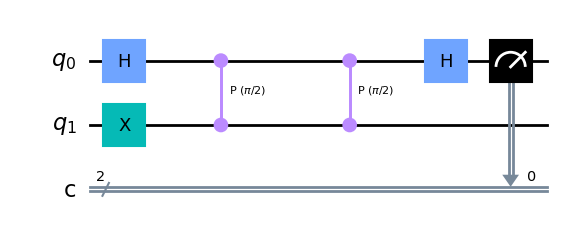

In [11]:
x_measurement(qc_S, q[0], c[0])
qc_S.draw('mpl')

### Subsequent steps (2nd step)

Now we build the quantum circuit for the other remaining steps, in this example, only the second one.
In these steps we have 4 sub-steps: the 3 sub-steps as in the first step and, in the middle, the additional step of the phase correction
- initialization with reset
- phase correction
- application of the Controlled-$U$ gates
- measure of the auxiliary qubit in x-basis

#### Initialization with reset

As we want to perform an iterative algorithm in the same circuit, we need to reset the auxiliary qubit $q0$ after the measument gate and initialize it again as before to recycle the qubit. 

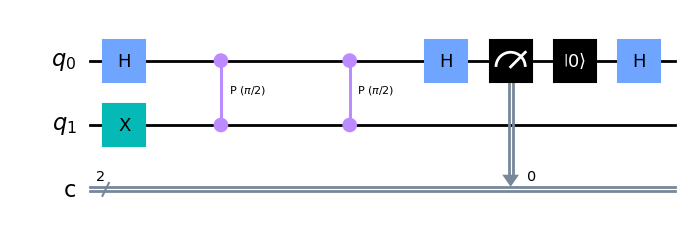

In [12]:
qc_S.reset(0)
qc_S.h(0)
qc_S.draw('mpl')

#### Phase correction (for step 2)
As seen in the theory, in order to extract the phase bit $\varphi_{1}$, we perform a phase correction of $-\pi\varphi_2/2$.
Of course, we need to apply the phase correction in the circuit only if the phase bit $\varphi_2=1$, i.e. we have to apply the phase correction of $-\pi/2$ only if the classical bit $c_0$ is 1.

So, after the reset we apply the phase gate $P(\theta)$ with phase $\theta=-\pi/2$ conditioned by the classical bit $c_0$ ($=\varphi_2$) using the `c_if` method.
So as we saw in the first part of this tutorial, we have to use the `c_if` method with a value of 1, as $1_{10} = 001_{2}$ (the subscripts $_{10}$ and $_2$ indicate the decimal and binary representations).

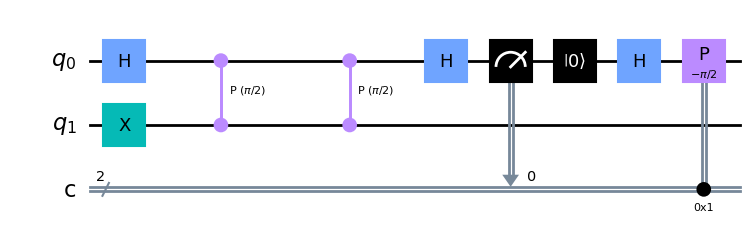

In [13]:
qc_S.p(-pi/2,0).c_if(c,1)
qc_S.draw('mpl')

#### Application of the Controlled-$U$ gates and x-measurement (for step 2)

We apply the $CU$ operations as we did in the first step. For the second step we have $t=m-2$, hence $2^t=1$. So we apply $\text{CP}(\pi/2)$ once. And then we perform the x-measurement of the qubit $q_0$, storing the result, the phase bit $\varphi_1$, in the bit $c_1$ of classical register.

In [14]:
## 2^t c-U operations (with t=m-2)
for _ in range(2**(m-2)):
    qc_S.cp(pi/2,0,1)

x_measurement(qc_S, q[0], c[1]) 

Et voilà, we have our final circuit

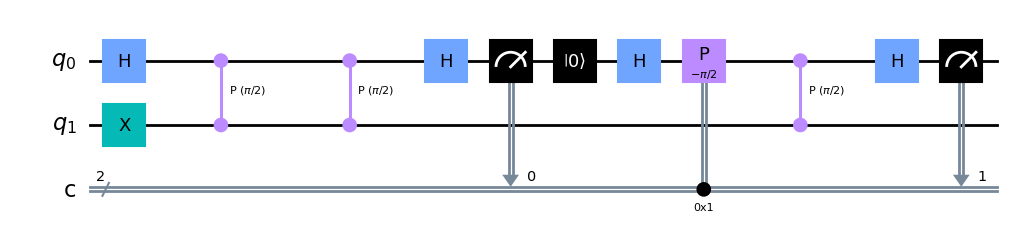

In [15]:
qc_S.draw('mpl')

Let's execute the circuit with the `qasm_simulator`, the simulator without noise that run locally.

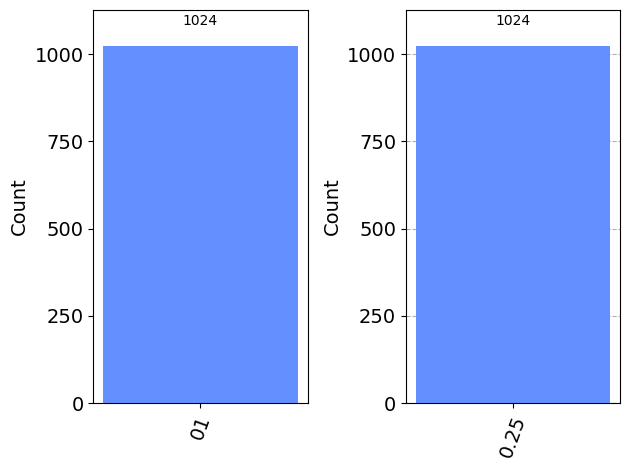

In [16]:
sim = Aer.get_backend('qasm_simulator')
count0 = execute(qc_S, sim).result().get_counts()

key_new = [str(int(key,2)/2**m) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
plt.tight_layout()

In the picture we have the same histograms but on the left we have on the x-axis the string with phase bits $\varphi_1$, $\varphi_2$ and on the right the actual phase $\varphi$ in decimal representation.

As we expected we have found $\varphi=\frac{1}{4}=0.25$ with a $100\%$ probability.

## IPE example with a 2-qubit gate

Now, we want to apply the IPE algorithm to estimate the phase for a 2-qubit gate $U$. For this example, let's consider the controlled version of the $T$ gate, i.e. the gate $U=\textrm{Controlled-}T$ (that from now we will express more compactly with $CT$). Its matrix is
$$ CT = 
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & e^\frac{i\pi}{4}\\ 
\end{bmatrix} $$
That is, the $CT$ gate adds a phase $\pi/4$ to the state $|11\rangle$, leaving unchanged the phase of the other computational basis states $|00\rangle$, $|01\rangle$, $|10\rangle$.

Let's consider to estimate the phase $\phi=\pi/4$ for the eigenstate $|11\rangle$, we should find $\varphi=1/8$, since $\phi = 2 \pi \varphi$. Therefore to estimate the phase we need exactly 3 classical bits, i.e. $m=3$, since $1/2^3=1/8$. So $\varphi=0.\varphi_1\varphi_2\varphi_3$.

As done with the example for the 1-qubit $U$ operator we will go through the same steps but this time we will have $3$ steps since $m=3$, and we will not repeat all the explanations. So for details see the above example for 1-qubit $U$ gate.

First, we initialize the circuit with 3 qubits, 1 for the auxiliary qubit and 2 for the 2-qubit gate, and 3 classical bits to store the phase bits $\varphi_1$, $\varphi_2$, $\varphi_3$.

In [17]:
nq = 3    # number of qubits
m = 3    # number of classical bits
q = QuantumRegister(nq,'q')
c = ClassicalRegister(m,'c')

qc = QuantumCircuit(q,c)

### First step

Now we build the quantum circuit for the first step, to estimate the least significant phase bit $\varphi_m=\varphi_3$.

#### Initialization

We initialize the auxiliary qubit and the other qubits with the eigenstate $|11\rangle$.

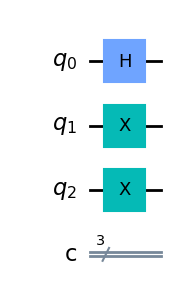

In [18]:
qc.h(0)
qc.x([1,2])
qc.draw('mpl')

#### Application of the Controlled-$U$ gates

Then we have to apply multiple times the $CU$ operator, that, in this example, is the Controlled-$CT$ gate ($CCT$ for short).

To implement $CCT$ in the circuit, since $T$ is a phase gate, we can use the multi-controlled phase gate $\text{MCP}(\theta)$, with $\theta=\pi/4$.

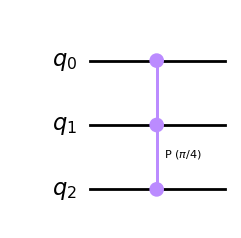

In [19]:
cu_circ = QuantumCircuit(nq)
cu_circ.mcp(pi/4,[0,1],2)
cu_circ.draw('mpl')

Let's apply $2^t$ times $\text{MCP}(\pi/4)$. Since for the first step $t=m-1$ and $m=3$, we have $2^t=4$.

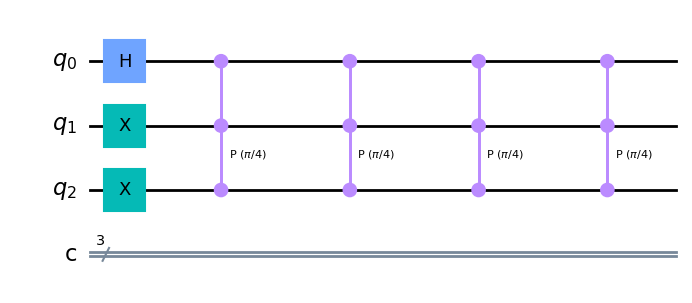

In [20]:
for _ in range(2**(m-1)):
    qc.mcp(pi/4,[0,1],2)
qc.draw('mpl')

#### Measure in x-basis

Finally, we perform the measurement of the auxiliary qubit in x-basis.
We can use the `x_measurement` function defined above in the example for 1-qubit gate. In this way we have obtained the phase bit $\varphi_3$ and stored it in the classical bit $c_0$.

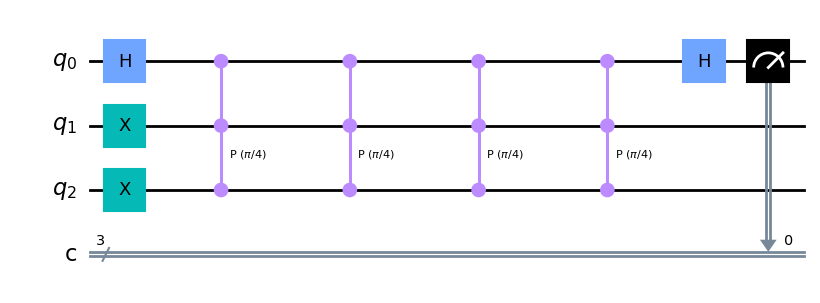

In [21]:
x_measurement(qc, q[0], c[0])
qc.draw('mpl')

### Subsequent steps (2nd, 3rd)

Now we build the quantum circuit for the other remaining steps, the second and the third ones.
As said in the first example, in these steps we have the additional sub-step of the phase correction.

#### Initialization with reset


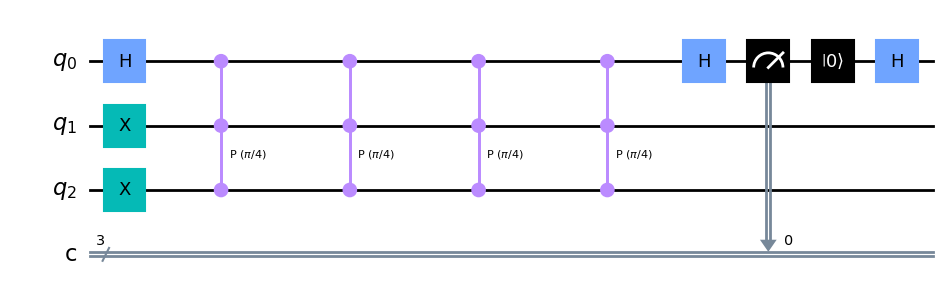

In [22]:
qc.reset(0)
qc.h(0)
qc.draw('mpl')

#### Phase correction (for step 2)
In order to extract the phase bit $\varphi_{2}$, we perform a phase correction of $-\pi\varphi_3/2$.

So, after the reset we apply the phase gate $P(\theta)$ with phase $\theta=-\pi/2$ conditioned by the classical bit $c_0$ ($=\varphi_3$).

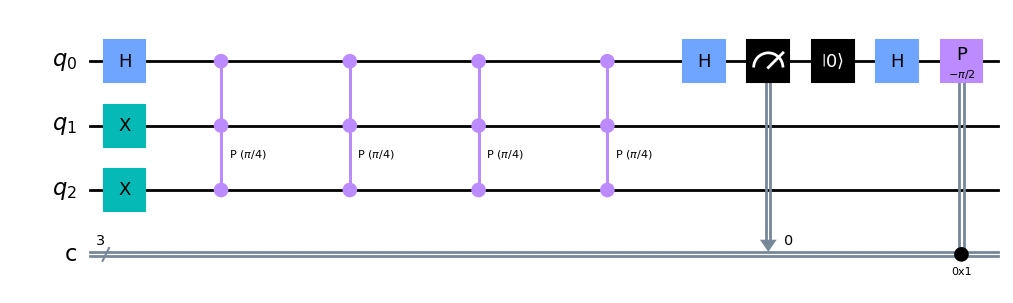

In [23]:
qc.p(-pi/2,0).c_if(c,1)
qc.draw('mpl')

#### Application of the Controlled-$U$ gates and x-measurement (for step 2)
We apply the $CU$ operations as we did in the first step. For the second step we have $t=m-2$, hence $2^t=2$. So we apply $\text{MCP}(\pi/4)$ $2$ times. And then we perform the x-measurement of the qubit $q_0$, storing the phase bit $\varphi_2$ in the bit $c_1$.

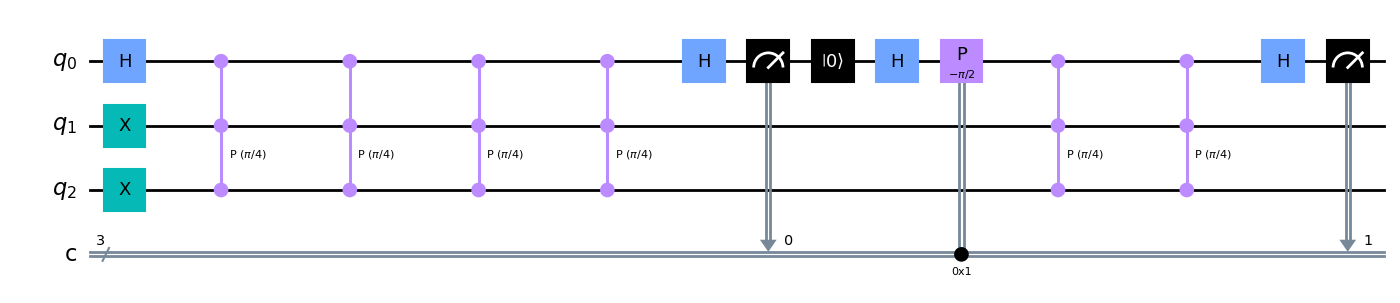

In [24]:
for _ in range(2**(m-2)):
    qc.mcp(pi/4,[0,1],2)
x_measurement(qc, q[0], c[1])
qc.draw('mpl')

#### All substeps of the 3rd step
For the 3rd and last step, we perform the reset and initialization of the auxiliary qubit as done in the second step.

Then at the 3rd step we have to perform the phase correction of $-2\pi 0.0\varphi_{2}\varphi_{3}= -2\pi \left(\frac{\varphi_2}{4}+\frac{\varphi_3}{8}\right)=-\frac{\varphi_2\pi}{2}-\frac{ \varphi_3\pi}{4}$, thus we have to apply 2 conditioned  phase corrections, one conditioned by $\varphi_3$ ($=c_0$) and the other by $\varphi_2$($=c_1$). To do this we have to apply the following:
- gate $P(-\pi/4)$ conditioned by $c_0=1$, that is, by $c=001$ (c_if with value $1$)
- gate $P(-\pi/2)$ conditioned by $c_1=1$, that is, the gate is applied when $c=010$ (c_if with values $2$)
- gate $P(-3\pi/4)$ conditioned by $c_1=1$ and $c_0=1$ that is, the gate is applied when $c=011$ (c_if with values $3$)

Next, the $CU$ operations: we apply $2^t$ times the $\text{MCP}(\pi/4)$ gate and since at the 3rd step $t=m-3=0$, we apply the gate only once.

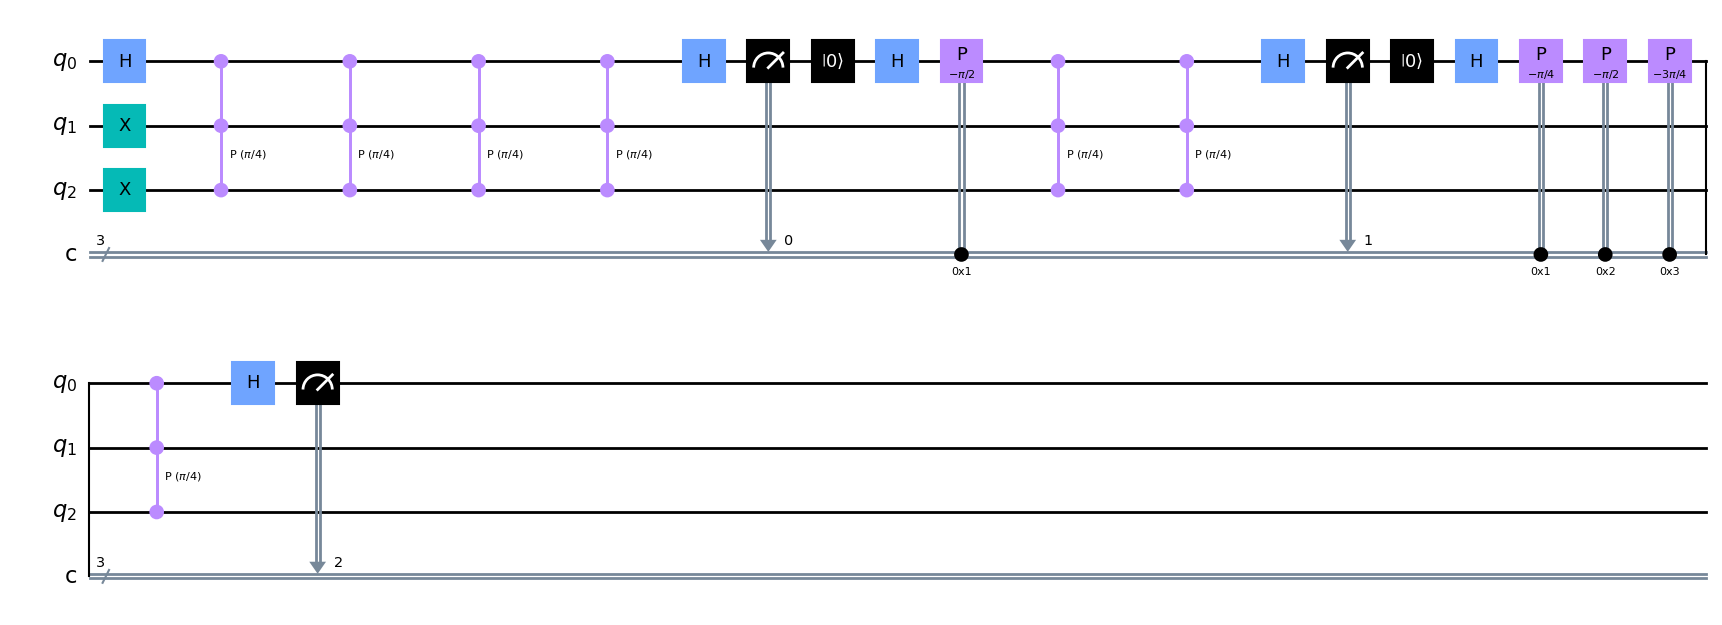

In [25]:
# initialization of qubit q0
qc.reset(0)
qc.h(0)

# phase correction
qc.p(-pi/4,0).c_if(c,1)

qc.p(-pi/2,0).c_if(c,2)
qc.p(-3*pi/4,0).c_if(c,3)

# c-U operations
for _ in range(2**(m-3)):
    qc.mcp(pi/4,[0,1],2)

# X measurement  
qc.h(0)
qc.measure(0,2)

qc.draw('mpl')

Now, we execute the circuit with the simulator without noise.

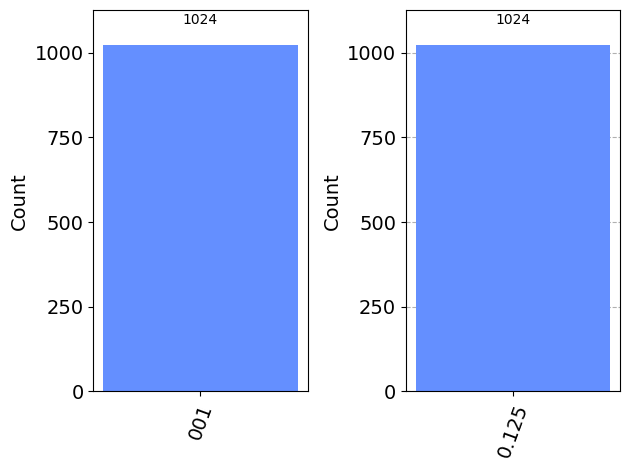

In [26]:
count0 = execute(qc, sim).result().get_counts()

key_new = [str(int(key,2)/2**m) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
fig.tight_layout()


We have obtained $100\%$ probability to find $\varphi=0.125$, that is, $1/8$, as expected.

In [27]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright